# S&P 500 週足 メディアン統計

In [1]:
import sys
path_up = '..'
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import yfinance as yf

from funcs.technical import calc_robust_bollinger

code = 'GSPC'
symbol = '^%s' % code
#symbol = 'USDJPY=X'
ticker = yf.Ticker(symbol)
df = ticker.history(period='3y', interval='1wk')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-03-28 00:00:00-04:00,4541.089844,4637.299805,4507.569824,4545.859863,23169700000,0.0,0.0
2022-04-04 00:00:00-04:00,4547.970215,4593.450195,4450.040039,4488.279785,23239490000,0.0,0.0
2022-04-11 00:00:00-04:00,4462.640137,4471.000000,4381.339844,4392.589844,16329620000,0.0,0.0
2022-04-18 00:00:00-04:00,4385.629883,4512.939941,4267.620117,4271.779785,21597890000,0.0,0.0
2022-04-25 00:00:00-04:00,4255.339844,4308.450195,4124.279785,4131.930176,24637900000,0.0,0.0
...,...,...,...,...,...,...,...
2025-02-24 00:00:00-05:00,6026.689941,6043.649902,5837.660156,5954.500000,26733210000,0.0,0.0
2025-03-03 00:00:00-05:00,5968.330078,5986.089844,5666.290039,5770.200195,27908150000,0.0,0.0
2025-03-10 00:00:00-04:00,5705.370117,5705.370117,5504.649902,5638.939941,27732600000,0.0,0.0


In [3]:
df0 = ticker.history(period='5y', interval='1wk')
df0

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-03-30 00:00:00-04:00,2558.979980,2641.389893,2447.489990,2488.649902,30852490000,0.0,0.0
2020-04-06 00:00:00-04:00,2578.280029,2818.570068,2574.570068,2789.820068,27229510000,0.0,0.0
2020-04-13 00:00:00-04:00,2782.459961,2879.219971,2721.169922,2874.560059,27176880000,0.0,0.0
2020-04-20 00:00:00-04:00,2845.620117,2868.979980,2727.100098,2836.739990,26590900000,0.0,0.0
2020-04-27 00:00:00-04:00,2854.649902,2954.860107,2821.610107,2830.709961,28845520000,0.0,0.0
...,...,...,...,...,...,...,...
2025-02-24 00:00:00-05:00,6026.689941,6043.649902,5837.660156,5954.500000,26733210000,0.0,0.0
2025-03-03 00:00:00-05:00,5968.330078,5986.089844,5666.290039,5770.200195,27908150000,0.0,0.0
2025-03-10 00:00:00-04:00,5705.370117,5705.370117,5504.649902,5638.939941,27732600000,0.0,0.0


## Moving Median

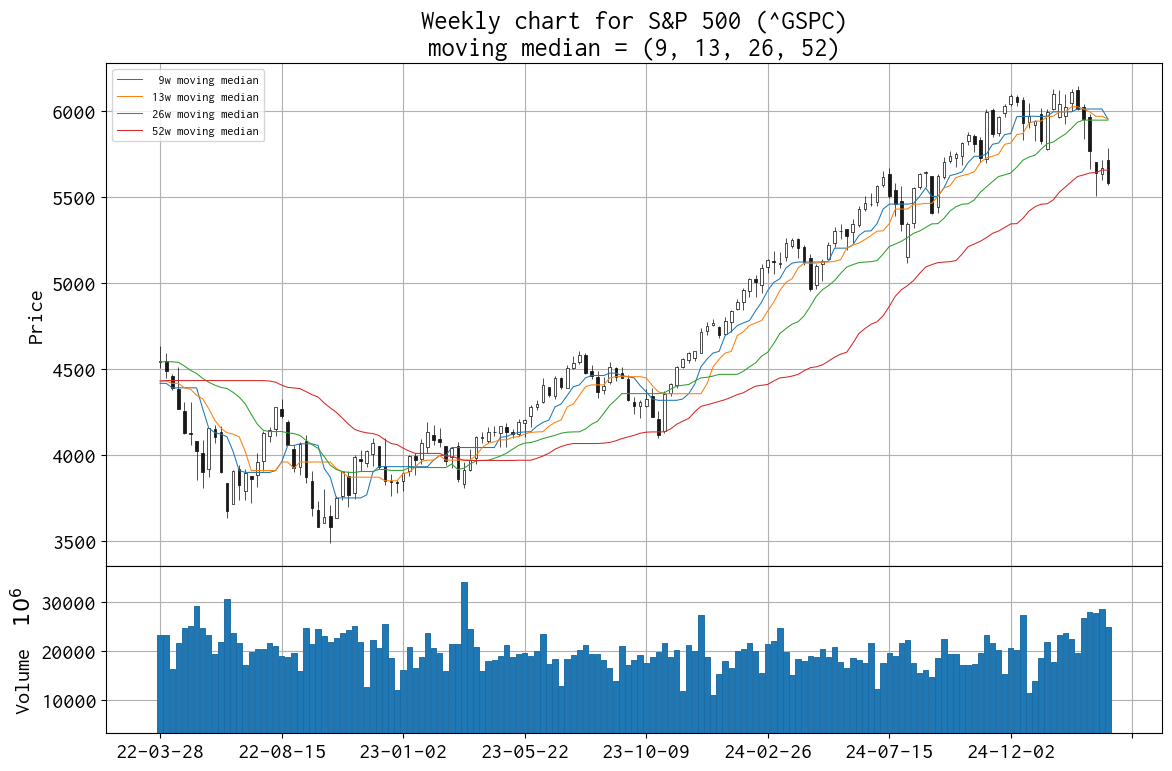

In [4]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(12, 8))
ax = dict()
n = 2
gs = fig.add_gridspec(
    n, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[3 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis
    ax[i].grid()

mm09 = df0['Close'].rolling(9).median()
mm13 = df0['Close'].rolling(13).median()
mm26 = df0['Close'].rolling(26).median()
mm52 = df0['Close'].rolling(52).median()

apds  = [
    mpf.make_addplot(mm09[df.index], width=0.75, label=' 9w moving median', ax=ax[0]),
    mpf.make_addplot(mm13[df.index], width=0.75, label='13w moving median', ax=ax[0]),
    mpf.make_addplot(mm26[df.index], width=0.75, label='26w moving median', ax=ax[0]),
    mpf.make_addplot(mm52[df.index], width=0.75, label='52w moving median', ax=ax[0]),
]   

mpf.plot(
    df, type='candle', style='default',
    volume=ax[1],
    datetime_format='%y-%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax[0],
)
ax[0].set_title('Weekly chart for %s (%s)\nmoving median = (9, 13, 26, 52)' %(ticker.info['longName'], symbol))
ax[0].legend(loc='upper left', fontsize=9)

plt.tight_layout()
plt.savefig('report_weekly_chart_median_%s.png' % code)
plt.show()

In [5]:
df.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-03-17 00:00:00-04:00,5635.600098,5715.330078,5597.759766,5667.560059,28404010000,0.0,0.0
2025-03-24 00:00:00-04:00,5718.080078,5786.950195,5572.419922,5580.939941,24922963000,0.0,0.0


In [6]:
df.tail(2)['Close']

Date
2025-03-17 00:00:00-04:00    5667.560059
2025-03-24 00:00:00-04:00    5580.939941
Name: Close, dtype: float64

In [7]:
df.tail(2)['Close'].diff()

Date
2025-03-17 00:00:00-04:00          NaN
2025-03-24 00:00:00-04:00   -86.620117
Name: Close, dtype: float64

In [8]:
df['Close'].tail(1) - df['Open'].tail(1)

Date
2025-03-24 00:00:00-04:00   -137.140137
dtype: float64

In [9]:
df['Close'].rolling(9).median().tail()

Date
2025-02-24 00:00:00-05:00    6013.129883
2025-03-03 00:00:00-05:00    6013.129883
2025-03-10 00:00:00-04:00    6013.129883
2025-03-17 00:00:00-04:00    6013.129883
2025-03-24 00:00:00-04:00    5954.500000
Name: Close, dtype: float64

In [10]:
df['Close'].rolling(13).median().tail()

Date
2025-02-24 00:00:00-05:00    6013.129883
2025-03-03 00:00:00-05:00    5996.660156
2025-03-10 00:00:00-04:00    5970.839844
2025-03-17 00:00:00-04:00    5970.839844
2025-03-24 00:00:00-04:00    5954.500000
Name: Close, dtype: float64

In [11]:
df['Close'].rolling(26).median().tail()

Date
2025-02-24 00:00:00-05:00    5948.485107
2025-03-03 00:00:00-05:00    5948.485107
2025-03-10 00:00:00-04:00    5948.485107
2025-03-17 00:00:00-04:00    5948.485107
2025-03-24 00:00:00-04:00    5948.485107
Name: Close, dtype: float64

In [12]:
df['Close'].rolling(52).median().tail()

Date
2025-02-24 00:00:00-05:00    5630.314941
2025-03-03 00:00:00-05:00    5641.504883
2025-03-10 00:00:00-04:00    5643.669922
2025-03-17 00:00:00-04:00    5657.979980
2025-03-24 00:00:00-04:00    5657.979980
Name: Close, dtype: float64

## Robust Bollinger bands

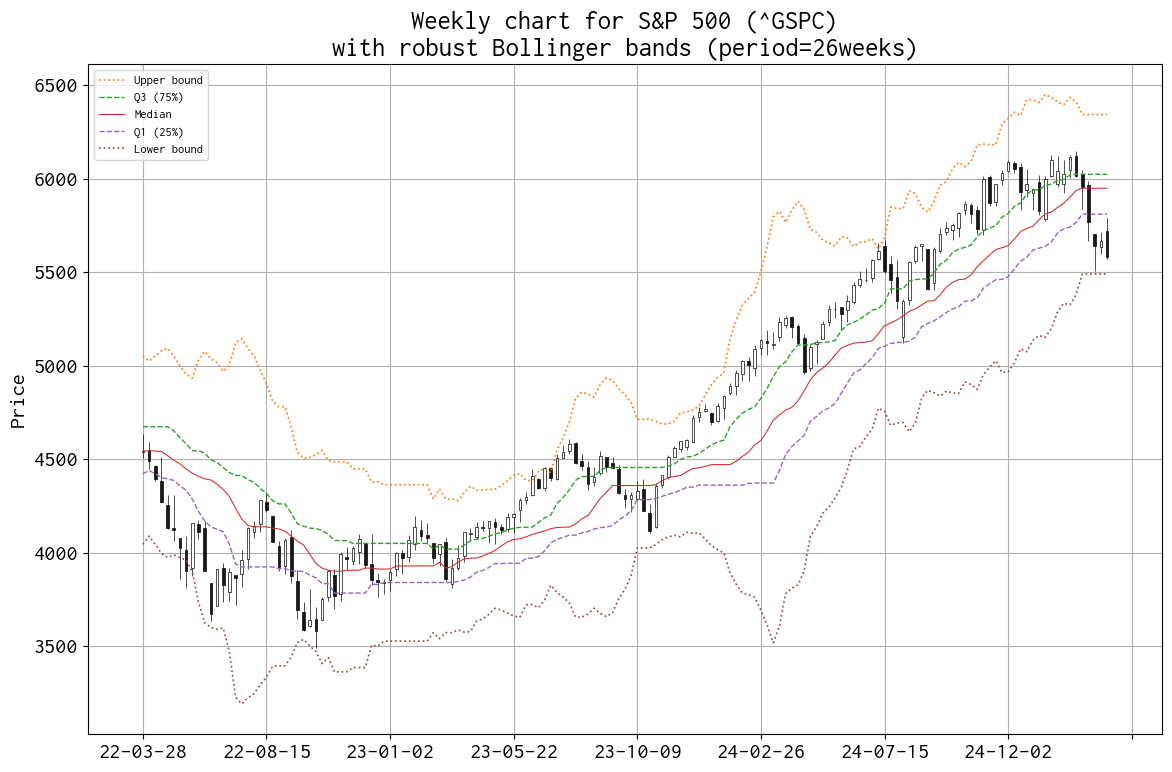

In [13]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 8))

# Bollinger bands
period = 26
mv_median = df0['Close'].rolling(period).median()
mv_q1 = df0['Close'].rolling(period).quantile(.25)
mv_q3 = df0['Close'].rolling(period).quantile(.75)
mv_iqr = mv_q3 - mv_q1
mv_lower = mv_q1 - mv_iqr * 1.5
mv_upper = mv_q3 + mv_iqr * 1.5

apds  = [
    mpf.make_addplot(mv_upper[df.index], width=1.25, color='C1', linestyle='dotted', label='Upper bound', ax=ax),
    mpf.make_addplot(mv_q3[df.index], width=1, color='C2', linestyle='dashed', label='Q3 (75%)', ax=ax),
    mpf.make_addplot(mv_median[df.index], width=0.75, color='C3', label='Median', ax=ax),
    mpf.make_addplot(mv_q1[df.index], width=1, color='C4', linestyle='dashed', label='Q1 (25%)', ax=ax),
    mpf.make_addplot(mv_lower[df.index], width=1.25, color='C5', linestyle='dotted', label='Lower bound', ax=ax),
]   

mpf.plot(
    df, type='candle', style='default',
    addplot=apds,
    datetime_format='%y-%m-%d',
    xrotation=0,
    ax=ax,
)

ax.grid()
ax.legend(loc='best', fontsize=9)

try:
    ax.set_title('Weekly chart for %s (%s)\nwith robust Bollinger bands (period=%dweeks)' % (ticker.info['longName'], symbol, period))
except KeyError:
    ax.set_title('Weekly chart for %s\nwith robust Bollinger bands (period=%sweeks)' % (symbol, period))

plt.tight_layout()
plt.savefig('report_weekly_chart_bollinger_robust_%s.png' % code)
plt.show()

## ヒストグラム

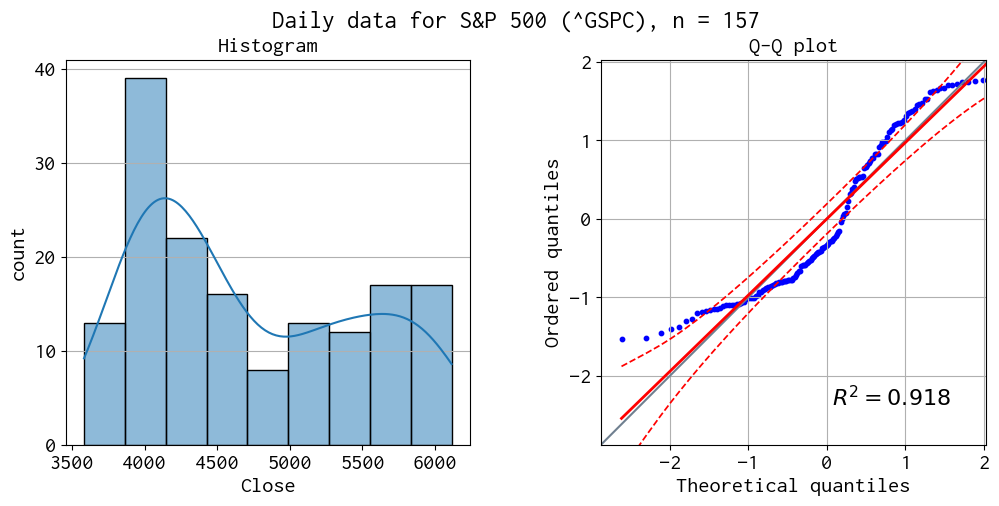

In [14]:
plt.rcParams['font.size'] = 16

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(
    df['Close'],
    kde=True,
    ax=axes[0]
)

# ヒストグラム
axes[0].set_xlabel("Close")
axes[0].set_ylabel("count")
axes[0].grid(axis = 'y')
axes[0].set_title('Histogram', fontsize=16)

# Q-Q プロット
pg.qqplot(df['Close'], s=10,  ax=axes[1])
axes[1].set_title('Q-Q plot', fontsize=16)
axes[1].grid()

plt.suptitle('Daily data for %s (%s), n = %d' % (ticker.info['longName'], symbol, len(df)), fontsize=18)
plt.subplots_adjust(wspace=0.3)
plt.savefig('report_daily_histogram_qqplot_%s.png' % code)
plt.show()